# Synthetic expression data from mutually exclusive switch Boolean network

In [1]:
import pandas as pd
import numpy as np
import random
from colomoto.minibn import * # for Boolean network manipulation
import networkx as nx # for graph manipulation
from scboolseq import scBoolSeq

# set seed for reproducible results
_rng_seed = 19834650
# use a Generator instead of numpy's singleton
_rng = np.random.default_rng(_rng_seed)
random.seed(_rng_seed)

This notebook has been executed using the docker image `bnediction/scboolseq:v0`

## Load Boolean network

In [2]:
bn = BooleanNetwork.load("models/switch.bnet")
bn

G1 <- TF1
G2 <- TF1
G3 <- TF1
G4 <- TF2
G5 <- TF2
G6 <- TF2
TF1 <- TF3&!TF2
TF2 <- TF3&!TF1
TF3 <- TF4
TF4 <- TF5
TF5 <- TF6
TF6 <- 1

# computing graph layout...


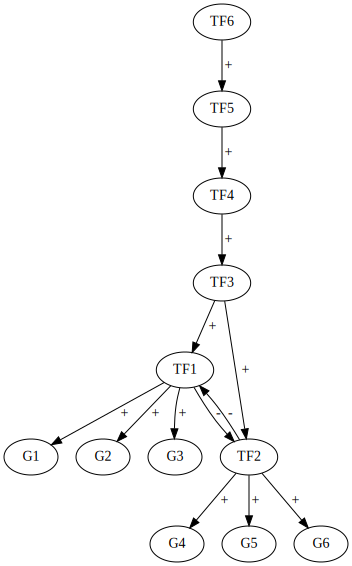

In [3]:
bn.influence_graph()

## Extract trajectories from the state transition graph

We consider the initial state where all the nodes are inactive, except TF6.

In [4]:
initial_state = bn.zero()
initial_state["TF6"] = 1
initial_state

{'G1': 0,
 'G2': 0,
 'G3': 0,
 'G4': 0,
 'G5': 0,
 'G6': 0,
 'TF1': 0,
 'TF2': 0,
 'TF3': 0,
 'TF4': 0,
 'TF5': 0,
 'TF6': 1}

We compute the state transition graph from the initial state, using the fully asynchronous update mode:

# computing graph layout...


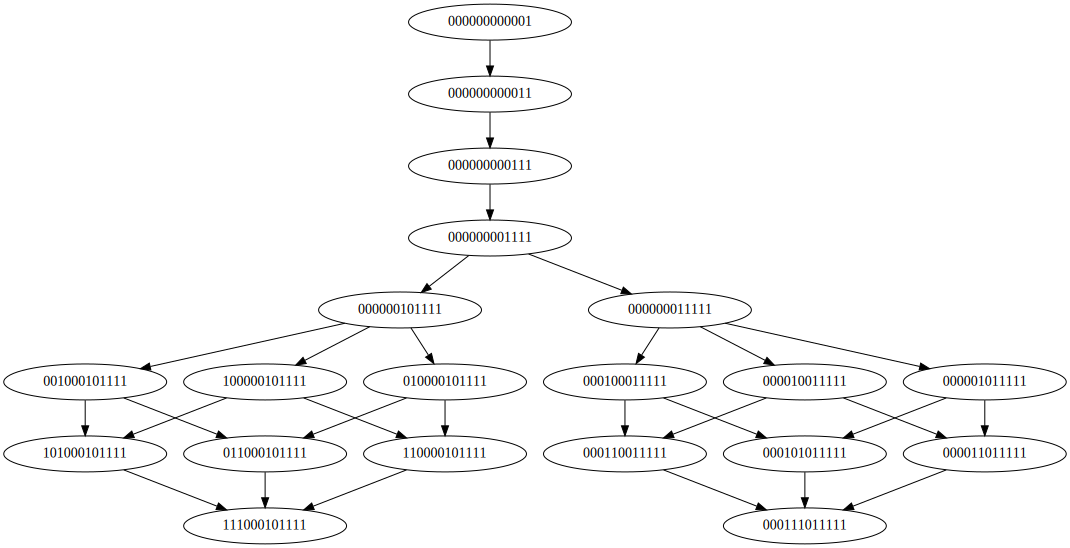

In [5]:
dynamics = FullyAsynchronousDynamics(bn)
stg = dynamics.partial_dynamics(initial_state)
stg

We can observe two stables states, one corresponding to TF1 (and G1-G3) being active, and one corresponding to TF2 (and G4-G6) active; the branching point is the state just before the activation of either TF1 or TF2 (where TF3-TF6 are active).

In [6]:
init = "000000000001"
branching = "000000001111"
stable1 = "111000101111"
stable2 = "000111011111"

# convert the binary representation of a state to a dict
def extract_state(name):
    return dict(zip(dynamics.nodes, map(int, name)))

We select the common path and two paths from the branching state to the stable states:

In [7]:
common = nx.shortest_path(stg, init, branching)
traj1 = nx.shortest_path(stg, branching, stable1)[1:]
traj2 = nx.shortest_path(stg, branching, stable2)[1:]
binstates = pd.DataFrame(map(extract_state, common+traj1+traj2))

# label the states
labels = [f"common.{i}" for i in range(len(common)-1)] + ["switch"]\
         + [f"branch1.{i}" for i in range(len(traj1)-1)] + ["stable1"] \
         + [f"branch2.{i}" for i in range(len(traj2)-1)] + ["stable2"]
binstates.index = labels
binstates.index.name = "label"

binstates

,G1,G2,G3,G4,G5,G6,TF1,TF2,TF3,TF4,TF5,TF6
label,,,,,,,,,,,,
common.0,0,0,0,0,0,0,0,0,0,0,0,1
common.1,0,0,0,0,0,0,0,0,0,0,1,1
common.2,0,0,0,0,0,0,0,0,0,1,1,1
switch,0,0,0,0,0,0,0,0,1,1,1,1
branch1.0,0,0,0,0,0,0,1,0,1,1,1,1
branch1.1,0,0,1,0,0,0,1,0,1,1,1,1
branch1.2,1,0,1,0,0,0,1,0,1,1,1,1
stable1,1,1,1,0,0,0,1,0,1,1,1,1
branch2.0,0,0,0,0,0,0,0,1,1,1,1,1


## Retrieve statistics of real expression datasets

We re-use statistics computed from a real scRNA-Seq dataset ([1 - Binarization and synthetic data generation](1%20-%20Binarization%20and%20synthetic%20data%20generation.ipynb)):

In [8]:
criteria = pd.read_csv("cache_scBoolSeq_Nestorowa_simulation_criteria.csv", index_col=0)
criteria.head()

,Dip,BI,Kurtosis,DropOutRate,MeanNZ,DenPeak,Amplitude,gaussian_prob1,gaussian_prob2,gaussian_mean1,gaussian_mean2,gaussian_variance,mean,variance,unimodal_margin_quantile,unimodal_low_quantile,unimodal_high_quantile,IQR,q50,bim_thresh_down,bim_thresh_up,Category,dor_threshold
Clec1b,9.948487e-01,1.635698,6.166711,0.876208,1.520978,-0.007249,8.852181,0.986140,0.013860,0.111291,5.666490,0.157649,1.520978,2.666760,0.25,0.667271,1.555290,0.888020,0.968776,2.785740,3.094168,Unimodal,NaN
Kdm3a,0.000000e+00,2.407548,-0.784019,0.326087,3.847940,0.209239,10.126676,0.714520,0.285480,0.872643,6.899449,1.278247,2.593177,8.692586,0.25,0.000000,5.258984,5.258984,1.268040,3.432251,4.748643,Bimodal,0.95
Coro2b,4.684039e-03,2.320060,0.327060,0.658213,2.383819,0.004597,9.475577,0.919508,0.080492,0.335546,6.289079,0.487372,2.383819,5.370521,0.25,0.827740,2.912944,2.085205,1.290666,3.183596,3.879537,Bimodal,NaN
8430408G22Rik,7.236739e-08,3.121069,-0.993979,0.884058,2.983472,0.005663,9.067857,0.964962,0.035038,0.098898,7.148808,0.172506,2.983472,8.154647,0.25,0.825298,6.465074,5.639776,1.449779,3.612061,4.175572,Bimodal,NaN
Clec9a,1.000000e+00,2.081717,140.089285,0.965580,2.280293,-0.009361,9.614233,0.993961,0.006039,0.035599,7.138099,0.069870,0.078488,0.372878,0.25,0.000000,0.000000,0.000000,0.000000,3.113410,4.607253,Discarded,0.95


In [9]:
criteria.Category.value_counts()

Bimodal      2987
Unimodal     1580
Discarded     201
Name: Category, dtype: int64

We randomly select bimodal genes for each of the nodes of the Boolean model to obtain simulation criteria:

In [10]:
pd.Series(bn.keys())

0      G1
1      G2
2      G3
3      G4
4      G5
5      G6
6     TF1
7     TF2
8     TF3
9     TF4
10    TF5
11    TF6
dtype: object

In [11]:
random_criteria = criteria[
    (criteria.Category == "Bimodal") &
    (criteria.DropOutRate < 0.05)
].sample(len(bn), random_state=_rng_seed)
random_criteria.set_index(pd.Series(bn.keys()), inplace=True)
random_criteria

,Dip,BI,Kurtosis,DropOutRate,MeanNZ,DenPeak,Amplitude,gaussian_prob1,gaussian_prob2,gaussian_mean1,gaussian_mean2,gaussian_variance,mean,variance,unimodal_margin_quantile,unimodal_low_quantile,unimodal_high_quantile,IQR,q50,bim_thresh_down,bim_thresh_up,Category,dor_threshold
G1,0.000250,1.982430,-1.118390,0.027778,4.454848,2.231509,10.458465,0.634321,0.365679,2.449688,7.594680,1.562365,4.331102,7.707162,0.25,2.070391,6.920502,4.850112,3.321480,4.277351,6.081385,Bimodal,0.95
G2,0.000000,2.171544,-1.148314,0.021135,6.223047,8.243204,11.193184,0.363906,0.636094,2.579439,8.100760,1.496439,6.091521,8.558219,0.25,3.183970,8.483865,5.299895,7.282884,4.384796,5.990926,Bimodal,0.95
G3,0.000000,1.957530,-1.273249,0.044082,5.641087,8.029818,10.794851,0.409065,0.590935,2.258246,7.561991,1.774518,5.392416,8.579517,0.25,2.585510,7.994901,5.409391,6.129123,3.802762,5.780924,Bimodal,0.95
G4,0.000000,2.123630,-1.315039,0.036836,5.724870,8.076334,10.811316,0.400338,0.599662,2.237126,7.701644,1.589570,5.513990,8.763508,0.25,2.536712,8.106769,5.570057,6.452676,3.963904,5.713590,Bimodal,0.95
G5,0.000000,2.161170,-1.344687,0.018116,6.559400,9.543728,12.260558,0.403231,0.596769,2.734372,8.944811,1.987133,6.440570,11.275156,0.25,3.109483,9.439844,6.330361,7.471017,4.771986,6.660780,Bimodal,0.95
G6,0.000000,2.167416,-1.386505,0.038647,5.661639,8.154579,10.498523,0.436231,0.563769,2.322133,7.857554,1.604112,5.442832,9.145257,0.25,2.480269,8.141719,5.661451,6.272476,4.156733,5.870370,Bimodal,0.95
TF1,0.000000,2.355317,-1.505761,0.034420,5.745117,8.722360,11.401288,0.433551,0.566449,2.015794,8.250379,1.720748,5.547368,11.273438,0.25,2.068712,8.581835,6.513123,6.533317,4.226884,5.879037,Bimodal,0.95
TF2,0.000000,2.307954,-0.861903,0.005435,6.800339,8.655035,10.931065,0.303185,0.696815,2.875043,8.455204,1.234993,6.763381,7.818094,0.25,4.108445,8.919568,4.811123,7.855844,4.817005,6.135923,Bimodal,0.95
TF3,0.000000,2.296122,-1.483351,0.043478,5.821394,8.961177,11.437198,0.489454,0.510546,2.422383,8.584236,1.799614,5.568290,11.294318,0.25,2.438392,8.763361,6.324968,5.836308,4.631891,6.354470,Bimodal,0.95
TF4,0.001038,1.593895,0.246388,0.035628,4.116075,3.382096,10.321775,0.813953,0.186047,3.118572,7.691919,1.246723,3.969428,4.416692,0.25,2.683685,4.560455,1.876770,3.506317,4.993969,6.611602,Bimodal,0.95


## Generate synthetic RNA-Seq data

In [12]:
scbool = scBoolSeq(simulation_criteria=random_criteria)
scbool

scBoolSeq(has_data=False, can_binarize=False, can_simulate=True)

In [13]:
n_samples = 400 # number of samples per row

In [14]:
counts = scbool.simulate(binstates, n_samples=n_samples, seed=1928327465)
counts.head()

,G1,G2,G3,G4,G5,G6,TF1,TF2,TF3,TF4,TF5,TF6
label,,,,,,,,,,,,
common.0,4.475878,3.413416,2.066811,0.950199,3.336355,1.888492,2.143407,2.827156,3.128409,3.241729,3.160564,8.576299
common.1,3.557386,3.292180,0.000000,0.905081,1.928840,2.264032,1.729205,2.029369,3.774732,4.643855,8.786762,8.133134
common.2,2.874816,3.799006,1.655275,1.741044,3.564899,2.556455,1.484213,3.336749,2.794175,8.316287,9.599411,6.680486
switch,4.648306,4.773053,2.380968,2.966153,4.482121,2.441165,2.142174,1.684118,7.435096,8.989888,7.694891,8.372901
branch1.0,2.639329,2.524278,1.555012,1.119877,2.308185,1.355019,8.866440,3.217094,9.757331,7.760155,7.587219,7.814503


In [15]:
counts.shape

(4800, 12)

We generate unique identifiers for each row (cell):

In [16]:
ids = [f"{x}_{y}"  for y in range(n_samples) for x in binstates.index]
counts.index = ids
counts.index.name = "cellID"
counts

,G1,G2,G3,G4,G5,G6,TF1,TF2,TF3,TF4,TF5,TF6
cellID,,,,,,,,,,,,
common.0_0,4.475878,3.413416,2.066811,0.950199,3.336355,1.888492,2.143407,2.827156,3.128409,3.241729,3.160564,8.576299
common.1_0,3.557386,3.292180,0.000000,0.905081,1.928840,2.264032,1.729205,2.029369,3.774732,4.643855,8.786762,8.133134
common.2_0,2.874816,3.799006,1.655275,1.741044,3.564899,2.556455,1.484213,3.336749,2.794175,8.316287,9.599411,6.680486
switch_0,4.648306,4.773053,2.380968,2.966153,4.482121,2.441165,2.142174,1.684118,7.435096,8.989888,7.694891,8.372901
branch1.0_0,2.639329,2.524278,1.555012,1.119877,2.308185,1.355019,8.866440,3.217094,9.757331,7.760155,7.587219,7.814503
...,...,...,...,...,...,...,...,...,...,...,...,...
stable1_399,7.945739,6.942587,11.350192,2.187738,3.539528,2.586831,7.900087,4.112845,9.937768,6.845818,7.846382,8.259726
branch2.0_399,1.781937,3.425767,1.064837,1.906039,0.086330,1.652100,2.540313,8.677465,8.306472,8.437082,9.155366,6.583032
branch2.1_399,4.394633,1.417074,3.133291,6.715675,2.788833,1.227657,2.137910,8.055768,9.709771,6.976481,8.203585,8.638054


Write as TSV file:

In [17]:
counts.T.to_csv("synthetic_data_switch_counts.tsv", sep="\t")

We generate metadata to validate a trajectory reconstruction:

In [18]:
def label_of_index(idx):
    return idx.split(".")[0]
labels = [label_of_index(idx) for idx in binstates.index]

color_map = {
    "common": "#aec7e8",
    "switch": "#1f78b4",
    "branch1": "#98df8a",
    "stable1": "#2ca02c",
    "branch2": "#ff9896",
    "stable2": "#d62728"
}

In [19]:
metadata = [[l, color_map[l]] for l in labels]*n_samples
metadata = pd.DataFrame(metadata, columns=["label", "label_color"])
metadata.index = counts.index
metadata

,label,label_color
cellID,,
common.0_0,common,#aec7e8
common.1_0,common,#aec7e8
common.2_0,common,#aec7e8
switch_0,switch,#1f78b4
branch1.0_0,branch1,#98df8a
...,...,...
stable1_399,stable1,#2ca02c
branch2.0_399,branch2,#ff9896
branch2.1_399,branch2,#ff9896


In [20]:
metadata.to_csv("synthetic_data_switch_metadata.tsv", sep="\t")